### Methodolody

What I want to do is look at the practice sessions for each race and look at the long runs of each car to find the tyre deg, then apply that and work through lap by lap for the race.

Then obviously the pit stops are whatever has the lowest total race time.

This could be put futher into even looking at other cars and not pitting into traffic, but then we start getting quite complicated.

Really just want to do this as a proof of concept, then look into ML models. May come back and improve to compare to ML models.

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


## Collect data into df

In [8]:
def create_dataframe():
    # initialize db connection and session
    db_engine, db_session = init_db()

    # query data from the database
    query = db_session.query(
        RacingWeekend.year,
        RacingWeekend.round,
        Circuit.circuit_name,
        Driver.driver_name,
        Driver.driver_short,
        Lap.lap_num,
        Lap.lap_time,
        Lap.tyre,
        Lap.tyre_laps,
        Lap.pit,
        Session.session_type
    ).join(RacingWeekend.circuit) \
     .join(RacingWeekend.sessions) \
     .join(Session.laps) \
     .join(Lap.driver) \
     .join(RacingWeekend.season) \
     .all()

    # convert result to list of dicts
    data = []
    for row in query:
        data.append({
            'year': row.year,
            'round': row.round,
            'circuit_name': row.circuit_name,
            'driver_name': row.driver_name,
            'driver_short': row.driver_short,
            'lap_num': row.lap_num,
            'lap_time': row.lap_time,
            'tyre': row.tyre,
            'tyre_laps': row.tyre_laps,
            'pit': row.pit,
            'session_type': row.session_type
        })

    # create dataframe
    df = pd.DataFrame(data)


    return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())




['year', 'round', 'circuit_name', 'driver_name', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


### Calc tyre deg

So here i want to look at the practice sessions for a weekend, look at long runs for a car, then find out tyre deg

In [9]:
import pandas as pd

def get_max_tyre_laps_for_year_and_round(df, year, round_num):
    # filter data for the specified year and round
    specific_race_df = df[(df['year'] == year) & (df['round'] == round_num)]

    # initialize an empty list for max tyre laps data
    max_tyre_laps = []

    # loop over each unique driver
    for driver in specific_race_df['driver_name'].unique():
        # filter data for this driver
        driver_data = specific_race_df[specific_race_df['driver_name'] == driver]

        # loop over each tyre type
        for tyre in driver_data['tyre'].unique():
            # filter data for the current tyre type
            tyre_data = driver_data[driver_data['tyre'] == tyre]

            # get the maximum tyre laps for this driver and tyre type
            max_tyre_lap = tyre_data.loc[tyre_data['tyre_laps'].idxmax()]

            # append the data for the maximum tyre lap
            max_tyre_laps.append({
                'driver_name': driver,
                'tyre': tyre,
                'max_tyre_laps': max_tyre_lap['tyre_laps'],
                'lap_time': max_tyre_lap['lap_time']
            })

    # convert the list of max tyre laps data to a dataframe
    max_tyre_laps_df = pd.DataFrame(max_tyre_laps)

    return max_tyre_laps_df

# example usage:
year = 2022
round_num = 3
df_max_tyre_laps = get_max_tyre_laps_for_year_and_round(df, year, round_num)

# now df_max_tyre_laps contains the maximum tyre laps and corresponding lap times for each driver and tyre type
df_max_tyre_laps


,driver_name,tyre,max_tyre_laps,lap_time
0,Max Verstappen,1,11,85.086
1,Max Verstappen,2,18,99.466
2,Max Verstappen,3,20,83.306
3,Pierre Gasly,2,21,100.851
4,Pierre Gasly,1,18,86.835
5,Pierre Gasly,3,37,83.333
6,Sergio Perez,1,12,81.345
7,Sergio Perez,2,20,99.099
8,Sergio Perez,3,38,81.094
9,Fernando Alonso,3,39,122.407


All laps

In [10]:
import pandas as pd

def get_tyre_lap_times_for_year_and_round(df, year, round_num, std_threshold=1):
    # filter data for the specified year and round
    specific_race_df = df[(df['year'] == year) & (df['round'] == round_num)]
    
    # initialize an empty list for lap times by tyre laps
    tyre_lap_times = []

    # loop over each unique driver
    for driver in specific_race_df['driver_name'].unique():
        # filter data for this driver
        driver_data = specific_race_df[specific_race_df['driver_name'] == driver]

        # loop over each tyre type
        for tyre in driver_data['tyre'].unique():
            # filter data for the current tyre type
            tyre_data = driver_data[driver_data['tyre'] == tyre]

            # group data by tyre laps and calculate mean lap time
            tyre_lap_group = (
                tyre_data.groupby('tyre_laps')
                .agg({'lap_time': 'mean'})  # mean lap time for each tyre lap number
                .reset_index()
            )
            
            # calculate mean and std of lap times for this driver and tyre
            mean_lap_time = tyre_lap_group['lap_time'].mean()
            std_lap_time = tyre_lap_group['lap_time'].std()

            # filter laps within the standard deviation threshold
            filtered_lap_group = tyre_lap_group[abs(tyre_lap_group['lap_time'] - mean_lap_time) <= std_threshold * std_lap_time]

            # add driver and tyre info to the dataframe for plotting
            filtered_lap_group['driver_name'] = driver
            filtered_lap_group['tyre'] = tyre

            # append the filtered data
            tyre_lap_times.append(filtered_lap_group)

    # concatenate all dataframes into a single dataframe
    tyre_lap_times_df = pd.concat(tyre_lap_times, ignore_index=True)

    return tyre_lap_times_df

# example usage:
year = 2023
round_num = 3
df_tyre_lap_times = get_tyre_lap_times_for_year_and_round(df, year, round_num)

# now df_tyre_lap_times contains the filtered lap times
df_tyre_lap_times


/tmp/ipykernel_99429/2611007751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lap_group['driver_name'] = driver
/tmp/ipykernel_99429/2611007751.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lap_group['tyre'] = tyre
/tmp/ipykernel_99429/2611007751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,tyre_laps,lap_time,driver_name,tyre
0,1,107.514714,Max Verstappen,1
1,2,88.380500,Max Verstappen,1
2,3,106.242167,Max Verstappen,1
3,4,92.753600,Max Verstappen,1
4,6,89.420750,Max Verstappen,1
...,...,...,...,...
1104,8,90.229000,Oscar Piastri,4
1105,9,94.786000,Oscar Piastri,4
1106,11,90.609000,Oscar Piastri,4
1107,12,90.134000,Oscar Piastri,4


linear fit for tyre 3:
slope: -2.3287, intercept: 96.7702
polynomial fit for tyre 3 (degree 2):
coefficients: [  0.76762306 -10.08788353 110.98156654]


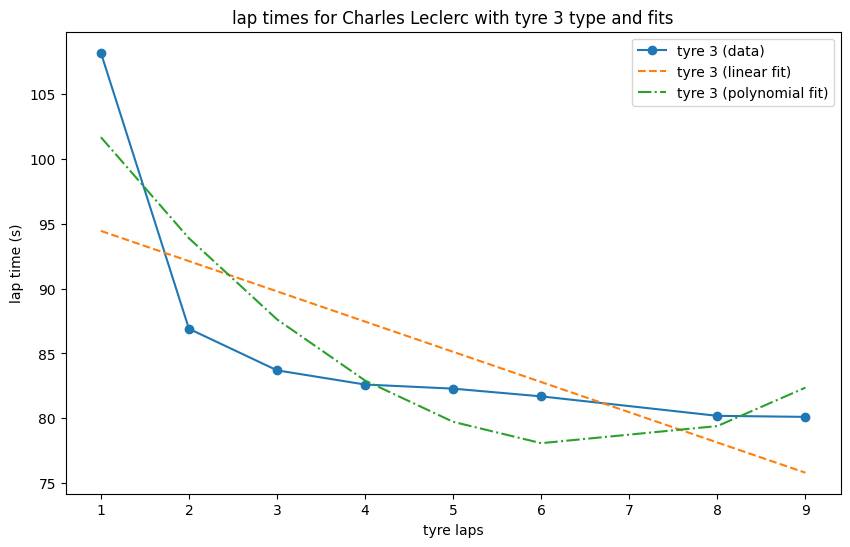

linear fit for tyre 1:
slope: -0.6108, intercept: 94.4510
polynomial fit for tyre 1 (degree 2):
coefficients: [ 4.18228671e-03 -6.98197902e-01  9.47774086e+01]


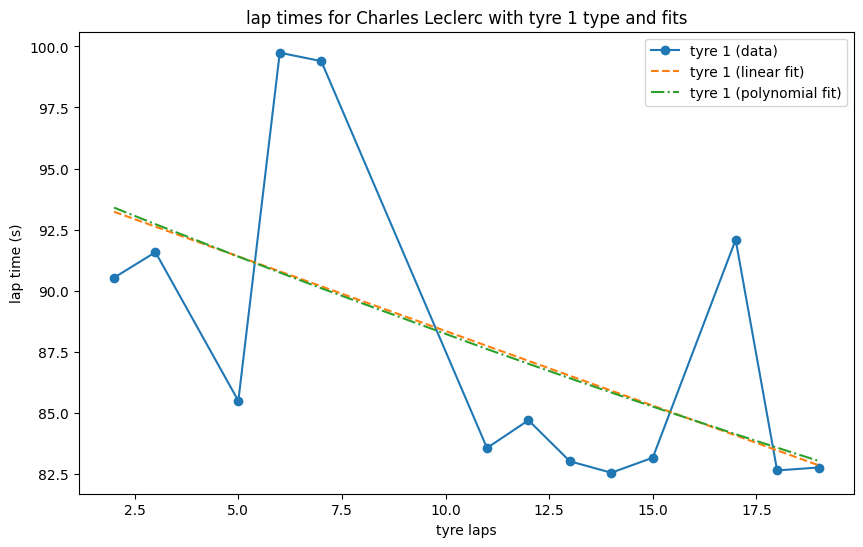

linear fit for tyre 2:
slope: 0.4508, intercept: 104.7303
polynomial fit for tyre 2 (degree 2):
coefficients: [  1.42025957  -9.37585677 117.35913918]


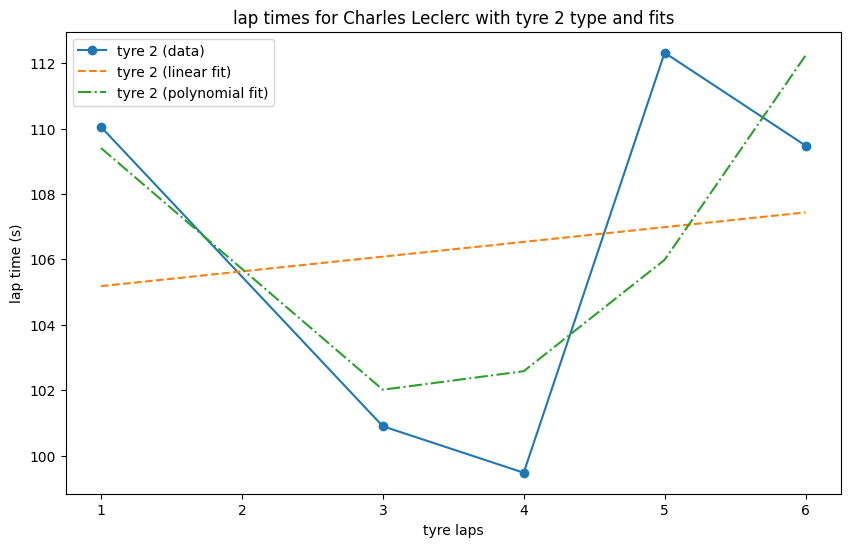

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

def plot_tyre_lap_times_for_driver(df, driver_name, poly_degree=2):
    # filter data for the specified driver
    driver_data = df[df['driver_name'] == driver_name]

    # loop through each tyre type
    for tyre in driver_data['tyre'].unique():
        # filter data for the current tyre type
        tyre_data = driver_data[driver_data['tyre'] == tyre]

        # create a plot for each tyre type
        plt.figure(figsize=(10, 6))

        # plot lap times for this tyre type
        plt.plot(tyre_data['tyre_laps'], tyre_data['lap_time'], label=f'tyre {tyre} (data)', marker='o')

        # linear fit
        slope, intercept, r_value, p_value, std_err = linregress(tyre_data['tyre_laps'], tyre_data['lap_time'])
        plt.plot(tyre_data['tyre_laps'], slope * tyre_data['tyre_laps'] + intercept, label=f'tyre {tyre} (linear fit)', linestyle='--')

        # print linear fit coefficients
        print(f"linear fit for tyre {tyre}:")
        print(f"slope: {slope:.4f}, intercept: {intercept:.4f}")
        
        # polynomial fit
        poly_coeff = np.polyfit(tyre_data['tyre_laps'], tyre_data['lap_time'], poly_degree)
        poly_fit = np.poly1d(poly_coeff)
        plt.plot(tyre_data['tyre_laps'], poly_fit(tyre_data['tyre_laps']), label=f'tyre {tyre} (polynomial fit)', linestyle='-.')

        # print polynomial fit coefficients
        print(f"polynomial fit for tyre {tyre} (degree {poly_degree}):")
        print(f"coefficients: {poly_coeff}")

        # labels and title
        plt.xlabel('tyre laps')
        plt.ylabel('lap time (s)')
        plt.title(f'lap times for {driver_name} with tyre {tyre} type and fits')
        plt.legend()

        # show the plot
        plt.show()

# example usage:
driver_name = 'Charles Leclerc'  # replace with the driver you want to plot for
plot_tyre_lap_times_for_driver(df_tyre_lap_times, driver_name)


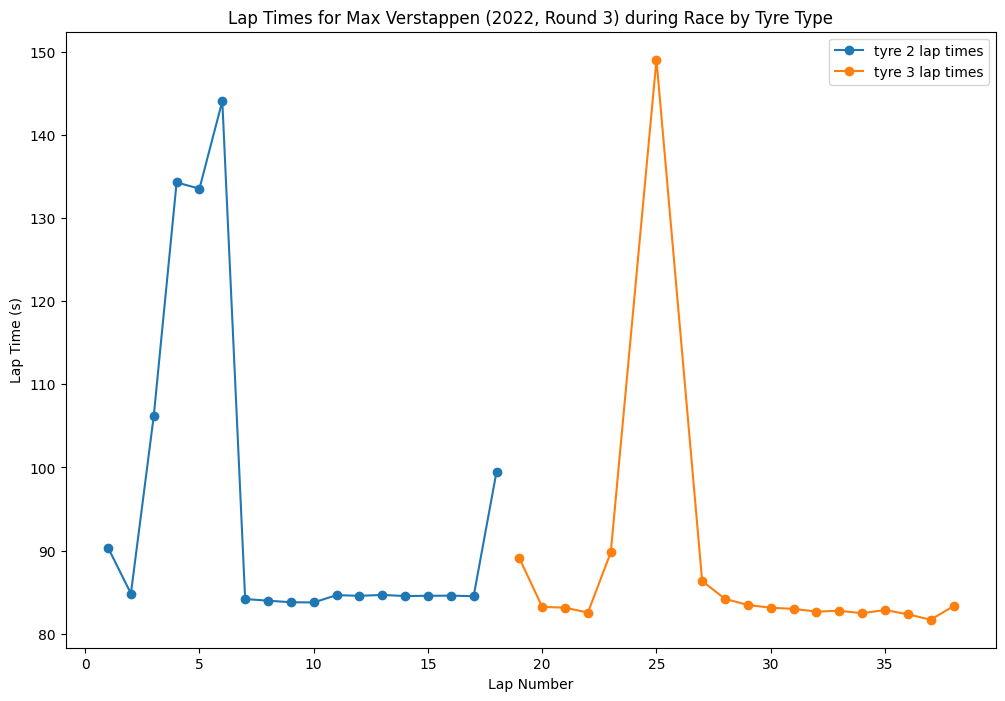

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_driver_lap_times_by_tyre(df, driver_name, year, round_num):
    # filter the dataframe for the specific year, round, driver, and session_type "Race"
    race_data = df[(df['year'] == year) & 
                   (df['round'] == round_num) & 
                   (df['driver_name'] == driver_name) & 
                   (df['session_type'] == 'Race')]

    # create a figure and axis for plotting
    plt.figure(figsize=(12, 8))

    # loop through each unique tyre type for the driver
    for tyre in race_data['tyre'].unique():
        # filter data for the current tyre type
        tyre_data = race_data[race_data['tyre'] == tyre]

        # plot the lap times for this tyre type
        plt.plot(tyre_data['lap_num'], tyre_data['lap_time'], marker='o', label=f'tyre {tyre} lap times')

    # add labels and title
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (s)')
    plt.title(f'Lap Times for {driver_name} ({year}, Round {round_num}) during Race by Tyre Type')
    plt.legend()

    # show the plot
    plt.show()

# example usage:
# assuming 'df' is your dataframe containing the lap times and related information
driver_name = 'Max Verstappen'
year = 2022
round_num = 3  # replace with the actual round number
plot_driver_lap_times_by_tyre(df, driver_name, year, round_num)
